## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu"


In [2]:

import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [3]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Dataset setup

In [4]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [6]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_1 (Reshape)              (None, 1, 2, 128)     0           reshape_input_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 1, 2, 132)     0           reshape_1[0][0]                  
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 256, 2, 130)   1024        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 2, 130)   0           conv1[0][0]                      
___________________________________________________________________________________________

In [7]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [8]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

/home/aaron/.local/lib/python2.7/site-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
22s - loss: 2.2915 - val_loss: 2.1901
Epoch 2/100
21s - loss: 2.1690 - val_loss: 2.0942
Epoch 3/100
21s - loss: 2.1023 - val_loss: 2.0458
Epoch 4/100
21s - loss: 2.0609 - val_loss: 2.0214
Epoch 5/100
21s - loss: 2.0299 - val_loss: 2.0109
Epoch 6/100
21s - loss: 2.0061 - val_loss: 1.9983
Epoch 7/100
21s - loss: 1.9843 - val_loss: 1.9950
Epoch 8/100
21s - loss: 1.9671 - val_loss: 1.9927
Epoch 9/100
21s - loss: 1.9463 - val_loss: 1.9831
Epoch 10/100
21s - loss: 1.9239 - val_loss: 1.9759
Epoch 11/100
21s - loss: 1.9044 - val_loss: 1.9677
Epoch 12/100
21s - loss: 1.8860 - val_loss: 1.9631
Epoch 13/100
21s - loss: 1.8665 - val_loss: 1.9566
Epoch 14/100
21s - loss: 1.8460 - val_loss: 1.9567
Epoch 15/100
21s - loss: 1.8350 - val_loss: 1.9564
Epoch 16/100
21s - loss: 1.8173 - val_loss: 1.9586
Epoch 17/100
21s - loss: 1.8021 - val_loss: 1.9540
Epoch 18/100
21s - loss: 1.7875 - val_loss: 1.9577
Epoch 19/100
21s - loss: 1.7743 - val_l

# Evaluate and Plot Model Performance

In [9]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0, batch_size=batch_size)
print score

/home/aaron/.local/lib/python2.7/site-packages/keras/models.py:644: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


1.95223090078


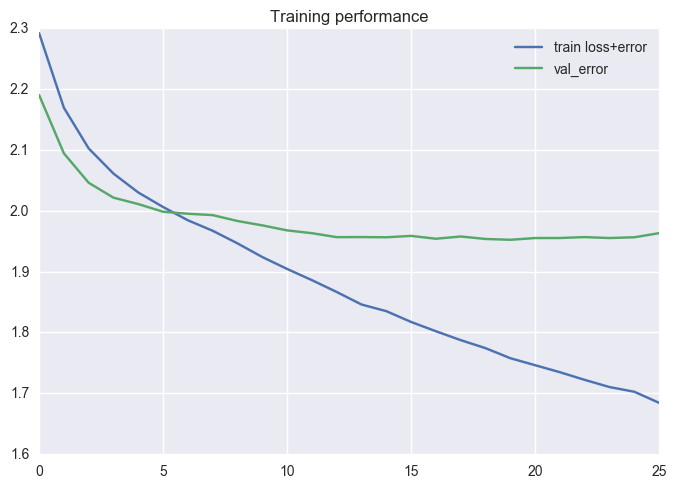

In [10]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [11]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

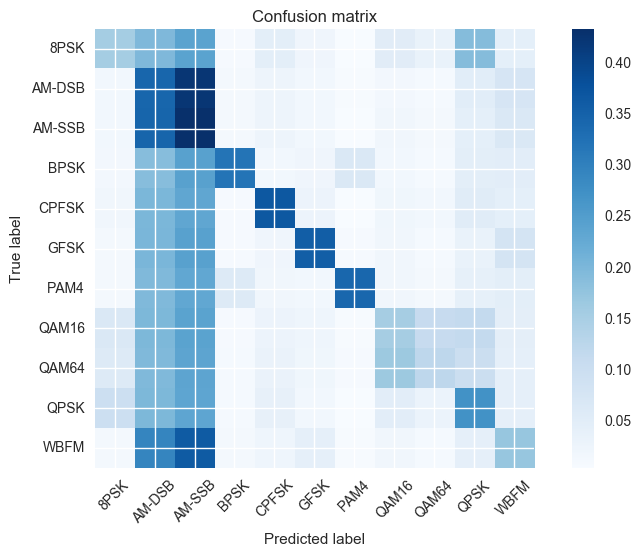

In [12]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.0935041171089
Overall Accuracy:  0.0841053587648
Overall Accuracy:  0.0938856729378
Overall Accuracy:  0.0931071815229
Overall Accuracy:  0.0958979033728
Overall Accuracy:  0.0870801492803
Overall Accuracy:  0.0848796619511
Overall Accuracy:  0.0907258064516
Overall Accuracy:  0.0964879852126
Overall Accuracy:  0.09706095791
Overall Accuracy:  0.112773722628
Overall Accuracy:  0.179752817157
Overall Accuracy:  0.313509544787
Overall Accuracy:  0.426714801444
Overall Accuracy:  0.521190261497
Overall Accuracy:  0.589435336976
Overall Accuracy:  0.609994568169
Overall Accuracy:  0.615058128806
Overall Accuracy:  0.626244343891
Overall Accuracy:  0.618541854185


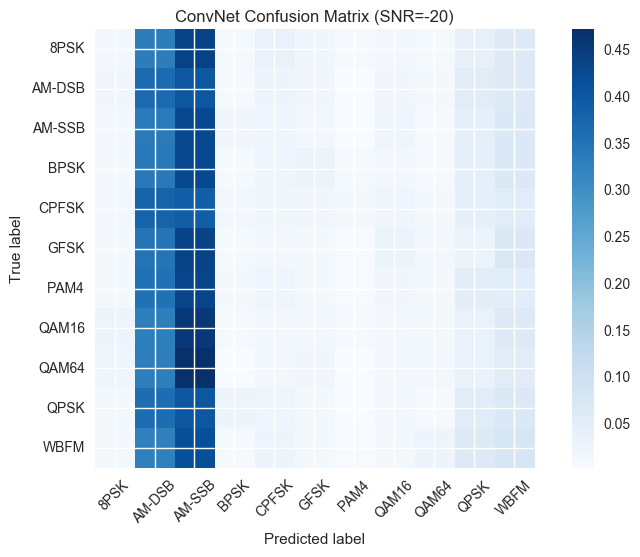

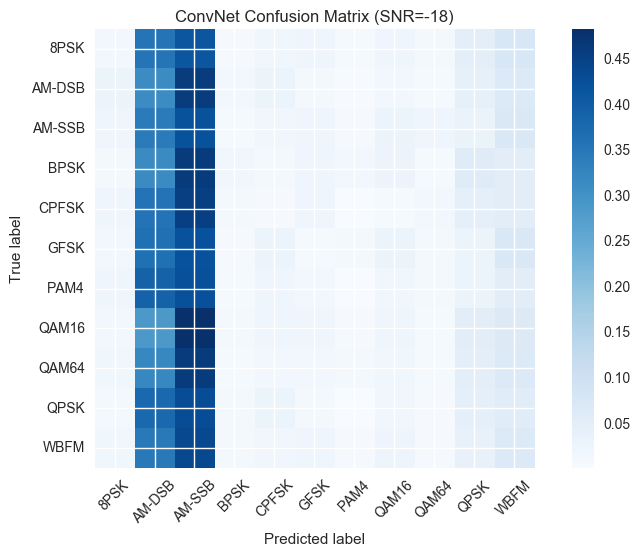

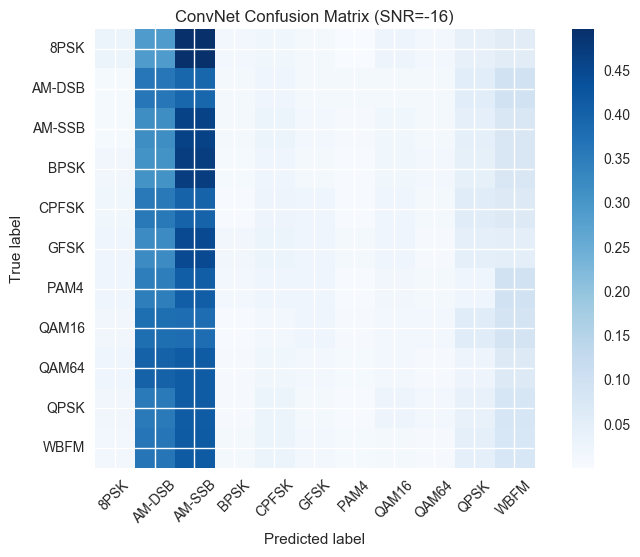

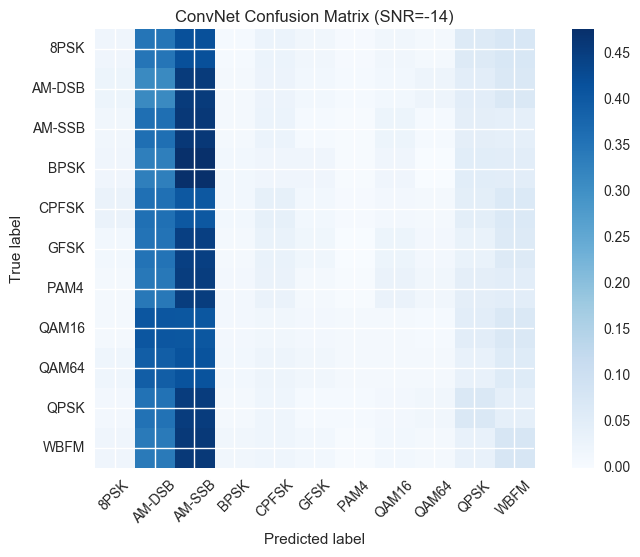

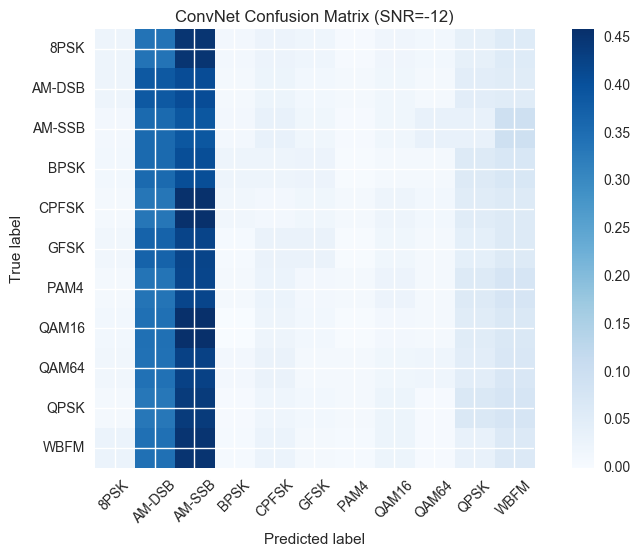

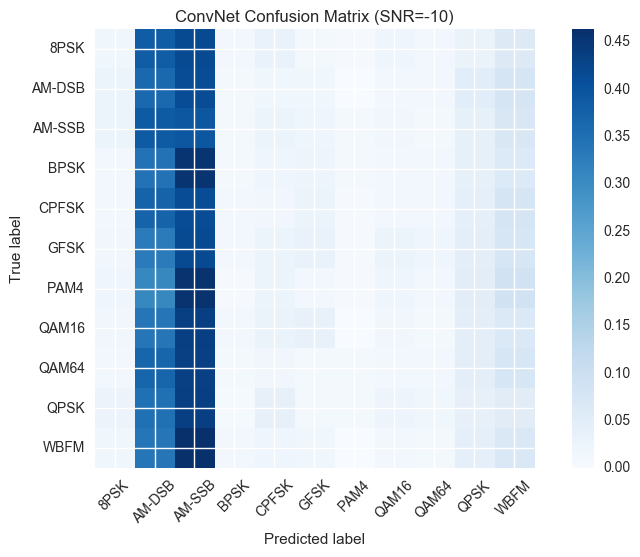

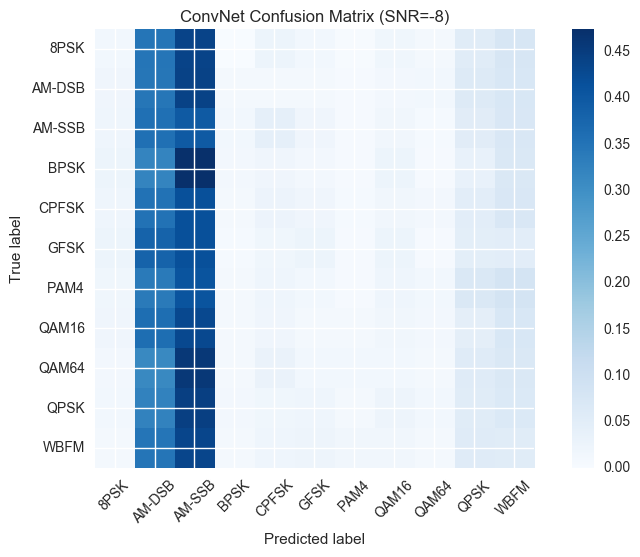

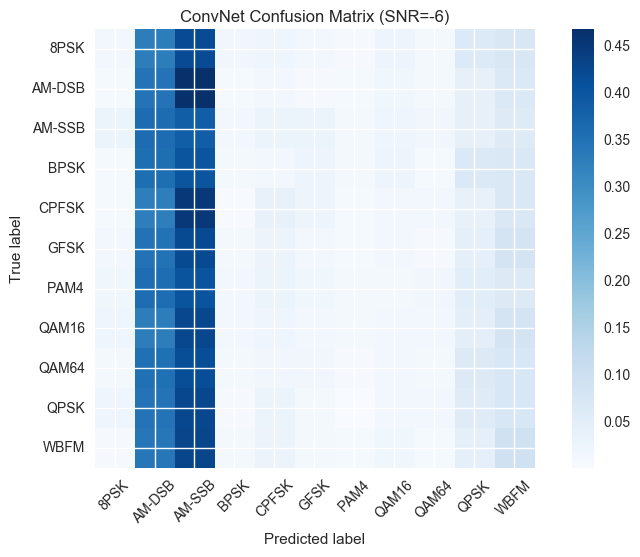

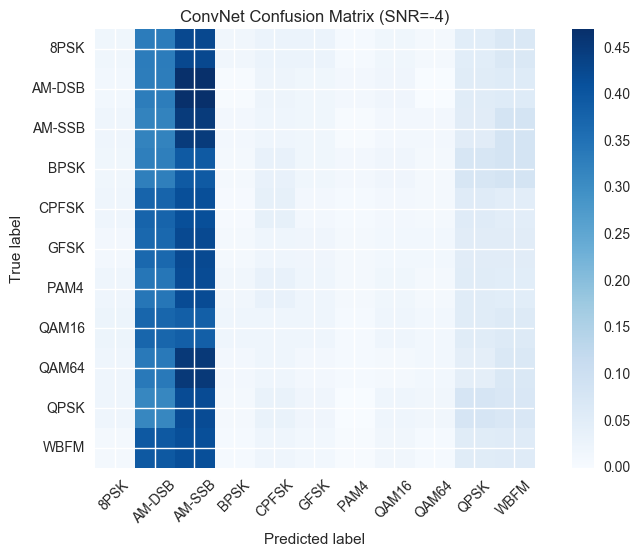

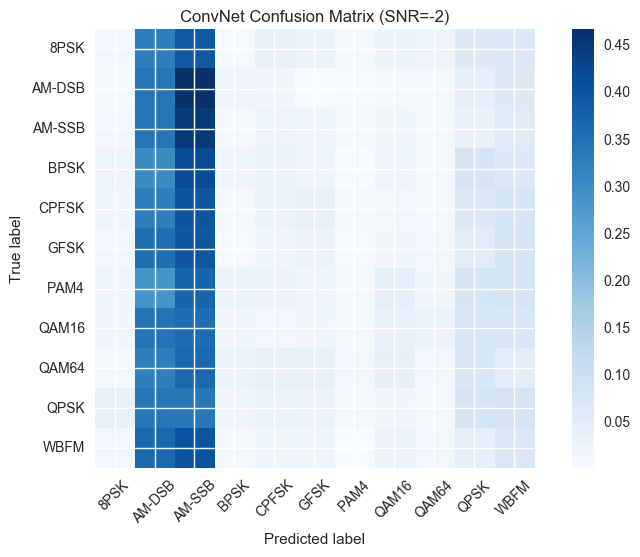

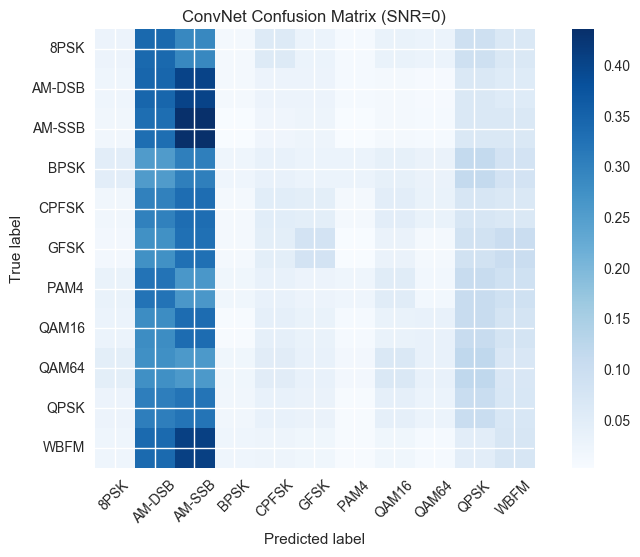

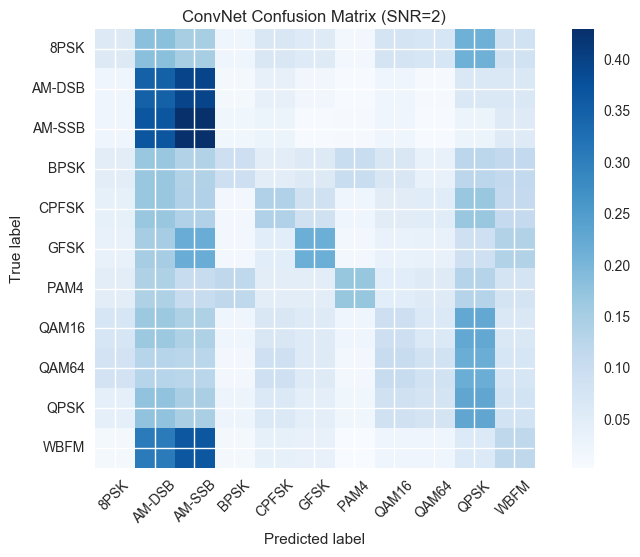

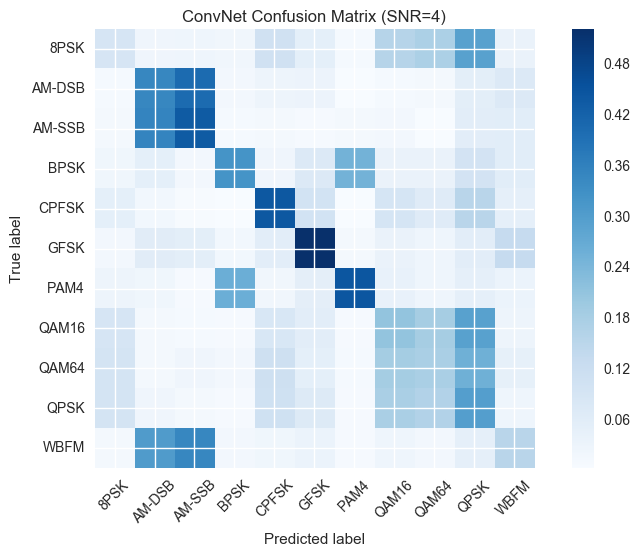

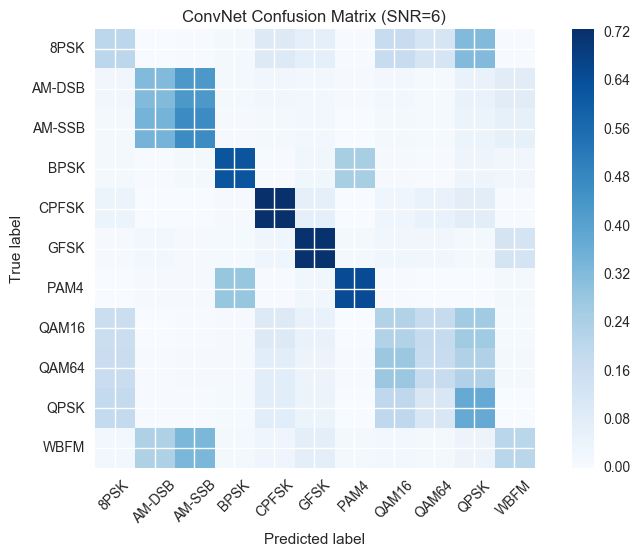

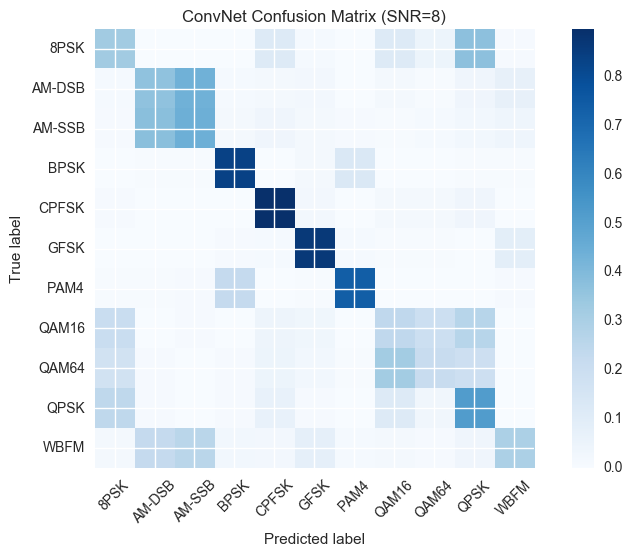

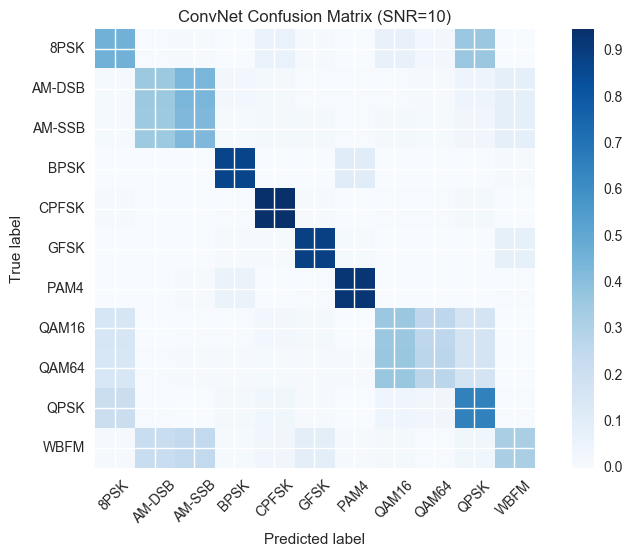

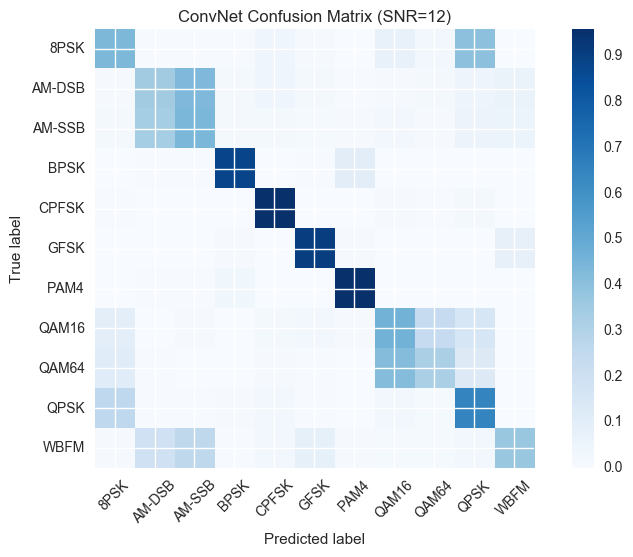

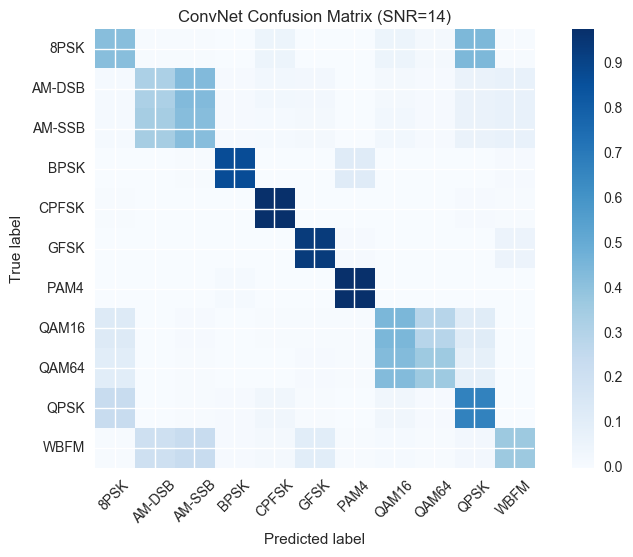

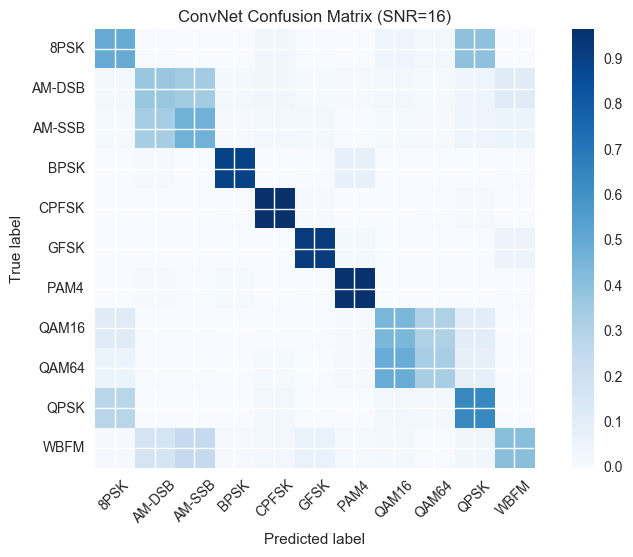

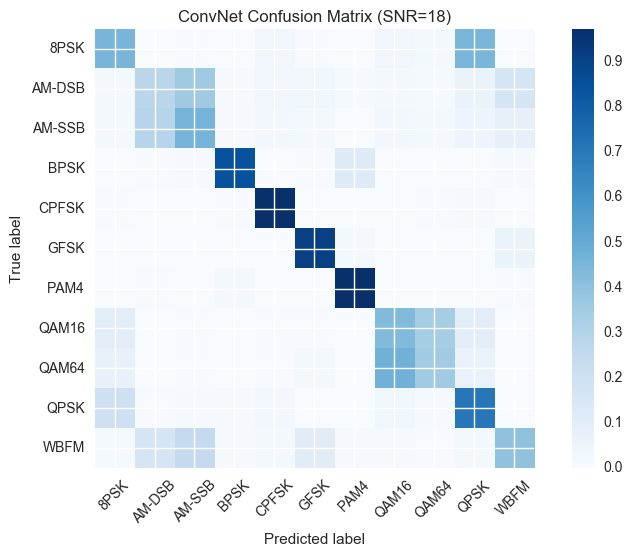

In [13]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)

In [14]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.11277372262773723, 16: 0.62624434389140271, 2: 0.1797528171573973, 4: 0.31350954478707782, 6: 0.42671480144404333, 8: 0.521190261496844, 12: 0.60999456816947306, 10: 0.58943533697632056, -20: 0.093504117108874657, 18: 0.61854185418541852, -18: 0.084105358764759316, -16: 0.09388567293777135, -14: 0.093107181522915916, -12: 0.095897903372835006, 14: 0.61505812880605282, -10: 0.087080149280255911, -8: 0.084879661951129892, -6: 0.090725806451612906, -4: 0.096487985212569322, -2: 0.097060957910014511}


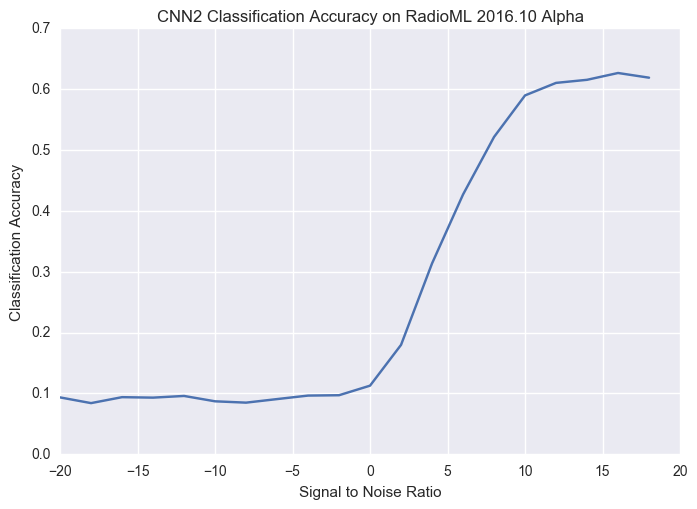

In [15]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha2")